# CNN – Classification Intel Image Classification

Objectif : entraîner un CNN pour une classification binaire
et analyser l’impact du nombre de convolutions.

In [20]:
# Import des librairies necessaires pour le traitement des images,
# la creation du CNN, l'entrainement du modele et le suivi des ressources
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import os
import time
import GPUtil
import psutil

In [21]:
# Parametres globaux pour la taille des images, le batch et le nombre d'epochs
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20

In [22]:
# Preparation des donnees pour le dataset Intel (classification multi-classes)
# Normalisation des images et augmentation de donnees pour l'entrainement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "../dataset/seg_train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"  # multiclasse
)

validation_generator = validation_datagen.flow_from_directory(
    "../dataset/seg_test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"  # multiclasse
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [23]:
# Fonction qui construit un CNN pour le dataset Intel
# Le modele peut avoir 2 ou 3 convolutions et est adapte a la classification multi-classes
def build_cnn(nb_conv):
    model = Sequential()

    # 1ère convolution
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(MaxPooling2D((2,2)))

    # 2ème convolution
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    # 3ème convolution optionnelle
    if nb_conv == 3:
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D((2,2)))

    # Passage en vecteur et couches denses
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # regularisation pour limiter l'overfitting
    model.add(Dense(6, activation='softmax'))  # 6 classes pour Intel

    # Compilation du modele
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [24]:
# Fonctions pour recuperer l'utilisation du CPU, de la RAM et du GPU pendant l'entrainement
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb

def get_gpu_stats():
    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None


In [25]:
# Callback personnalise pour afficher le temps et l'utilisation des ressources
# + fonction pour creer les callbacks (early stopping et sauvegarde des meilleurs poids)
class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)

def get_callbacks(nb_conv):
    # Creation du dossier pour stocker les poids du modele
    ckpt_dir = f"checkpoints_cnn_{nb_conv}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # Sauvegarde des meilleurs poids selon la validation
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "weights_epoch_{epoch:02d}.h5"),
        monitor="val_accuracy",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Early stopping pour arreter l'entrainement si la validation n'amelior plus
    early_stop = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    return checkpoint, early_stop, ckpt_dir

In [26]:
# Creation et entrainement du modele CNN a 2 convolutions sur le dataset Intel
model_2 = build_cnn(nb_conv=2)

checkpoint, early_stop, ckpt_dir = get_callbacks(2)

history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.5572
Epoch 1: val_accuracy improved from -inf to 0.63474, saving model to checkpoints_cnn_2\weights_epoch_01.h5
 | CPU: 2.2% | RAM: 15761 MB | Time: 49.2s | GPU: 5.0% | VRAM: 856.0/16303.0 MB
438/438 [==============================] - 49s 112ms/step - loss: 1.1502 - accuracy: 0.5572 - val_loss: 0.9365 - val_accuracy: 0.6347
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 0.9286 - accuracy: 0.6520
Epoch 2: val_accuracy improved from 0.63474 to 0.70430, saving model to checkpoints_cnn_2\weights_epoch_02.h5
 | CPU: 3.6% | RAM: 15807 MB | Time: 48.8s | GPU: 9.0% | VRAM: 856.0/16303.0 MB
438/438 [==============================] - 49s 111ms/step - loss: 0.9286 - accuracy: 0.6520 - val_loss: 0.7825 - val_accuracy: 0.7043
Epoch 3/20
438/438 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.6971
Epoch 3: val_accuracy improved from 0.70430 to 0.75907, saving mode

In [27]:
# Creation et entrainement du modele CNN a 3 convolutions pour le dataset Intel
model_3 = build_cnn(nb_conv=3)

checkpoint, early_stop, ckpt_dir = get_callbacks(3)

history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)


Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.5575
Epoch 1: val_accuracy improved from -inf to 0.67977, saving model to checkpoints_cnn_3\weights_epoch_01.h5
 | CPU: 2.3% | RAM: 15695 MB | Time: 51.3s | GPU: 2.0% | VRAM: 883.0/16303.0 MB
438/438 [==============================] - 51s 117ms/step - loss: 1.1305 - accuracy: 0.5575 - val_loss: 0.8409 - val_accuracy: 0.6798
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.6563
Epoch 2: val_accuracy improved from 0.67977 to 0.75974, saving model to checkpoints_cnn_3\weights_epoch_02.h5
 | CPU: 2.6% | RAM: 15666 MB | Time: 52.0s | GPU: 2.0% | VRAM: 883.0/16303.0 MB
438/438 [==============================] - 52s 119ms/step - loss: 0.9041 - accuracy: 0.6563 - val_loss: 0.6708 - val_accuracy: 0.7597
Epoch 3/20
438/438 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.7265
Epoch 3: val_accuracy improved from 0.75974 to 0.78293, saving mode

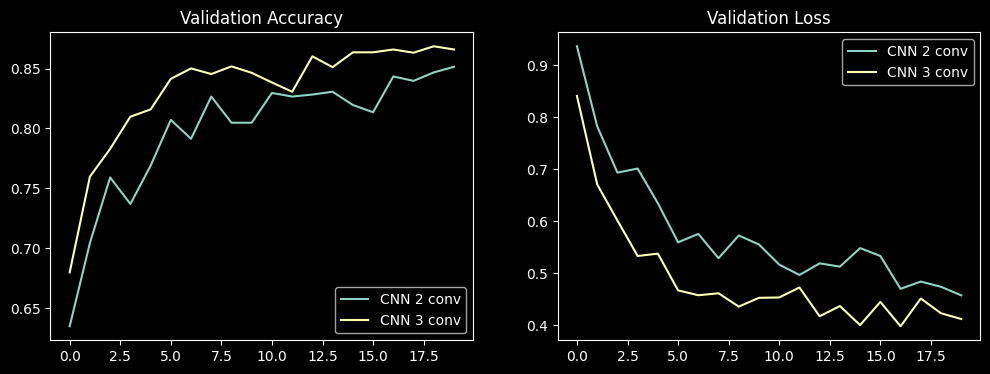

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_2.history["val_accuracy"], label="CNN 2 conv")
plt.plot(history_3.history["val_accuracy"], label="CNN 3 conv")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history["val_loss"], label="CNN 2 conv")
plt.plot(history_3.history["val_loss"], label="CNN 3 conv")
plt.title("Validation Loss")
plt.legend()

plt.show()


### Comparaison CNN 2 convolutions vs CNN 3 convolutions

L’entraînement des deux architectures montre que l’ajout d’une troisième couche de convolution améliore les performances du modèle, tout en conservant un entraînement stable sur ce nouveau dataset. Les tendances observées sont cohérentes avec celles obtenues précédemment sur le dataset Dogs & Cats.

CNN à 2 convolutions :

- Précision maximale sur l’ensemble de validation : 85,15 % (epoch 20)
- Perte de validation minimale : 0,4574
- Meilleur modèle atteint en fin d’entraînement, sans déclenchement de l’early stopping

CNN à 3 convolutions :

- Précision maximale sur l’ensemble de validation : 86,86 % (epoch 19)
- Perte de validation minimale : 0,4229
- Meilleur modèle atteint à l’epoch 19, avec une légère dégradation ensuite

Le graphique comparatif montre que le CNN à 3 convolutions converge plus rapidement et maintient une précision de validation supérieure à celle du CNN à 2 convolutions sur la majorité des epochs. La perte de validation plus faible observée pour le modèle à 3 convolutions traduit une meilleure capacité de généralisation, sans apparition d’overfitting significatif.

Ainsi, ce second jeu de données confirme que l’augmentation modérée de la profondeur d’un CNN améliore la performance globale du modèle, comme observé précédemment sur Dogs & Cats.

Lors de ces entraînements CNN, l’utilisation des ressources reste globalement faible et stable : le CPU tourne surtout autour de 1–4 % (avec quelques pointes vers 6 %), la RAM reste proche de 15,6–15,9 Go, et la VRAM reste < 1 Go (environ 856–935 Mo). L’utilisation GPU est modérée (souvent 2–5 %, avec un pic à 9 % sur le 3 conv), tandis que le temps par epoch est d’environ 49 s (2 conv) contre 51–54 s (3 conv), ce qui est cohérent avec un modèle plus profond.